<a href="https://colab.research.google.com/github/yunhyeongil/pandas_base/blob/main/2%EC%9D%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re, collections

In [ ]:
num_merges = 10

In [ ]:
dictionary = {'l o w </w>' : 5,
         'l o w e r </w>' : 2,
         'n e w e s t </w>':6,
         'w i d e s t </w>':3
         }

In [ ]:
def get_stats(dictionary):
  # 유니그램의 pair들의 빈도수를 카운트
  pairs = collections.defaultdict(int)
  for word, freq in dictionary.items():
    symbols = word.split()
    for i in range(len(symbols)-1):
      pairs[symbols[i], symbols[i+1]] += freq
  print('현재 pair들의 빈도수 :', dict(pairs))
  return pairs

In [ ]:
def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

In [ ]:
bpe_codes = {}
bpe_codes_reverse = {}

In [ ]:
for i in range(num_merges):
  print(">> Step {0}".format(i+1))
  pairs = get_stats(dictionary)
  best = max(pairs, key=pairs.get)
  dictionary = merge_dictionary(best, dictionary)

  bpe_codes[best] = i
  bpe_codes_reverse[best[0] + best[1]] = best

  print("new merge: {}".format(best))
  print("dictionary: {}".format(dictionary))

>> Step 1
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}
>> Step 2
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}
>> Step 3
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictiona

In [ ]:
print(bpe_codes)
# bpe_code를 출력하면 merge 했던 기록이 출력

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


## OOV에 대처하기

In [ ]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

In [ ]:
def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    #display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))
    print("__word split into characters:__ <tt>{}</tt>".format(word))

    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        #display(Markdown("__Iteration {}:__".format(iteration)))
        print("__Iteration {}:__".format(iteration))

        print("bigrams in the word: {}".format(pairs))
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        if bigram not in bpe_codes:
            #display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            print("__Candidate not in BPE merges, algorithm stops.__")
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # 특별 토큰인 </w>는 출력하지 않는다.
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

In [ ]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')</tt>
__Iteration 1:__
bigrams in the word: {('l', 'o'), ('o', 'k'), ('k', 'i'), ('i', '</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')
__Iteration 2:__
bigrams in the word: {('lo', 'k'), ('k', 'i'), ('i', '</w>')}
candidate for merging: ('lo', 'k')
__Candidate not in BPE merges, algorithm stops.__


('lo', 'k', 'i')

In [ ]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>
__Iteration 1:__
bigrams in the word: {('o', 'w'), ('e', 's'), ('s', 't'), ('w', 'e'), ('l', 'o'), ('t', '</w>')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')
__Iteration 2:__
bigrams in the word: {('o', 'w'), ('w', 'es'), ('es', 't'), ('l', 'o'), ('t', '</w>')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')
__Iteration 3:__
bigrams in the word: {('l', 'o'), ('est', '</w>'), ('o', 'w'), ('w', 'est')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')
__Iteration 4:__
bigrams in the word: {('l', 'o'), ('o', 'w'), ('w', 'est</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')
__Iteration 5:__
bigrams in the word: {('lo', 'w'), ('w', 'est</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')
__Iteration 6:__
bigrams in the word: {('low'

('low', 'est')

In [ ]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>
__Iteration 1:__
bigrams in the word: {('n', 'g'), ('o', 'w'), ('w', 'i'), ('i', 'n'), ('l', 'o'), ('g', '</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')
__Iteration 2:__
bigrams in the word: {('n', 'g'), ('w', 'i'), ('lo', 'w'), ('i', 'n'), ('g', '</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')
__Iteration 3:__
bigrams in the word: {('low', 'i'), ('n', 'g'), ('g', '</w>'), ('i', 'n')}
candidate for merging: ('low', 'i')
__Candidate not in BPE merges, algorithm stops.__


('low', 'i', 'n', 'g')

In [ ]:
encode("highing")

__word split into characters:__ <tt>('h', 'i', 'g', 'h', 'i', 'n', 'g', '</w>')</tt>
__Iteration 1:__
bigrams in the word: {('n', 'g'), ('g', 'h'), ('i', 'g'), ('i', 'n'), ('h', 'i'), ('g', '</w>')}
candidate for merging: ('n', 'g')
__Candidate not in BPE merges, algorithm stops.__


('h', 'i', 'g', 'h', 'i', 'n', 'g')

## IMDB리뷰 토큰화하기

In [ ]:
import tensorflow_datasets as tfds
import urllib.request
import pandas as pd

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7fafb4add410>)

In [ ]:
train_df = pd.read_csv('IMDb_Reviews.csv')

In [ ]:
train_df['review']

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object

In [ ]:
train_df['sentiment']

0        1
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    1
Name: sentiment, Length: 50000, dtype: int64

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_df['review'], target_vocab_size=2**13)

In [ ]:
print(tokenizer.subwords[:100])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 't_', 'as_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', 'are_', ' (', 'have_', 'his_', 'film_', 'not_', 'be_', 'you_', 'ing_', ' "', 'ed_', 'it', 'd_', 'an_', 'at_', 'by_', 'he_', 'one_', 'who_', 'from_', 'y_', 'or_', 'e_', 'like_', 'all_', '" ', 'they_', 'so_', 'just_', 'has_', ') ', 'about_', 'her_', 'out_', 'This_', 'some_', 'movie', 'ly_', 'film', 'very_', 'more_', 'It_', 'what_', 'would_', 'when_', 'if_', 'good_', 'up_', 'which_', 'their_', 'only_', 'even_', 'my_', 'really_', 'had_', 'can_', 'no_', 'were_', 'see_', '? ', 'she_', 'than_', '! ', 'there_', 'been_', 'get_', 'into_', 'will_', ' - ', 'much_', 'n_', 'because_', 'ing']


In [ ]:
print(train_df['review'][20])
# 21번째 샘플을 출력

Pretty bad PRC cheapie which I rarely bother to watch over again, and it's no wonder -- it's slow and creaky and dull as a butter knife. Mad doctor George Zucco is at it again, turning a dimwitted farmhand in overalls (Glenn Strange) into a wolf-man. Unfortunately, the makeup is virtually non-existent, consisting only of a beard and dimestore fangs for the most part. If it were not for Zucco and Strange's presence, along with the cute Anne Nagel, this would be completely unwatchable. Strange, who would go on to play Frankenstein's monster for Unuiversal in two years, does a Lenny impression from "Of Mice and Men", it seems.<br /><br />*1/2 (of Four)


In [ ]:
print("토큰화된 샘플 질문 : {}".format(tokenizer.encode(train_df['review'][20])))

토큰화된 샘플 질문 : [1590, 4162, 132, 7107, 1892, 2983, 578, 76, 12, 4632, 3422, 7, 160, 175, 372, 2, 5, 39, 8051, 8, 84, 2652, 497, 39, 8051, 8, 1374, 5, 3461, 2012, 48, 5, 2263, 21, 4, 2992, 127, 4729, 711, 3, 1391, 8044, 3557, 1277, 8102, 2154, 5681, 9, 42, 15, 372, 2, 3773, 4, 3502, 2308, 467, 4890, 1503, 11, 3347, 1419, 8127, 29, 5539, 98, 6099, 58, 94, 4, 1388, 4230, 8057, 213, 3, 1966, 2, 1, 6700, 8044, 9, 7069, 716, 8057, 6600, 2, 4102, 36, 78, 6, 4, 1865, 40, 5, 3502, 1043, 1645, 8044, 1000, 1813, 23, 1, 105, 1128, 3, 156, 15, 85, 33, 23, 8102, 2154, 5681, 5, 6099, 8051, 8, 7271, 1055, 2, 534, 22, 1, 3046, 5214, 810, 634, 8120, 2, 14, 71, 34, 436, 3311, 5447, 783, 3, 6099, 2, 46, 71, 193, 25, 7, 428, 2274, 2260, 6487, 8051, 8, 2149, 23, 1138, 4117, 6023, 163, 11, 148, 735, 2, 164, 4, 5277, 921, 3395, 1262, 37, 639, 1349, 349, 5, 2460, 328, 15, 5349, 8127, 24, 10, 16, 10, 17, 8054, 8061, 8059, 8062, 29, 6, 6607, 8126, 8053]


In [ ]:
sample_string1 = "It's mind-blowing to me that this film was even made."

# 인코딩해서 저장
tokenized_string1 = tokenizer.encode(sample_string1)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string1))

# 이를 다시 디코딩하자!
oringinal_string = tokenizer.decode(tokenized_string1)
print('기존 문장: {}'.format(oringinal_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 79, 681, 8058]
기존 문장: It's mind-blowing to me that this film was even made.


In [ ]:
sample_string2 = "It's mind-blowing to me that this film was even made."

# 인코딩해서 저장
tokenized_string2 = tokenizer.encode(sample_string2)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string2))

# 이를 다시 디코딩하자!
oringinal_string = tokenizer.decode(tokenized_string2)
print('기존 문장: {}'.format(oringinal_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 79, 681, 8058]
기존 문장: It's mind-blowing to me that this film was even made.


In [ ]:
print('단어 집합의 크기(Vocab size) :', tokenizer.vocab_size)

단어 집합의 크기(Vocab size) : 8268


In [ ]:
for ts in tokenized_string1:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

137 ----> It
8051 ----> '
8 ----> s 
910 ----> mind
8057 ----> -
2169 ----> blow
36 ----> ing 
7 ----> to 
103 ----> me 
13 ----> that 
14 ----> this 
32 ----> film 
18 ----> was 
79 ----> even 
681 ----> made
8058 ----> .


In [ ]:
sample_string = "It's mind-blowing to me that this film was evenxyz made."

In [ ]:
tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

#이를 다시 디코딩
oringinal_string = tokenizer.decode(tokenized_string)
print('기존 문장: {}'.format(oringinal_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 7974, 8132, 8133, 997, 681, 8058]
기존 문장: It's mind-blowing to me that this film was evenxyz made.


In [ ]:
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

137 ----> It
8051 ----> '
8 ----> s 
910 ----> mind
8057 ----> -
2169 ----> blow
36 ----> ing 
7 ----> to 
103 ----> me 
13 ----> that 
14 ----> this 
32 ----> film 
18 ----> was 
7974 ----> even
8132 ----> x
8133 ----> y
997 ----> z 
681 ----> made
8058 ----> .


## 파이썬 TF-IDF 구현

In [ ]:
import pandas as pd
from math import log

In [ ]:
docs = [
        '먹고 싶은 사과',
        '먹고 싶은 바나나',
        '길고 노란 바나나 바나나',
        '저는 과일이 좋아요'
]

In [ ]:
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()

In [ ]:
print(vocab)

['과일이', '길고', '노란', '먹고', '바나나', '사과', '싶은', '저는', '좋아요']


In [ ]:
N = len(docs)
print(N)

4


In [ ]:
def tf(t,d):
  return d.count(t)

In [ ]:
def idf(t):
  df = 0
  for doc in docs:
    df += t in doc
  return log(N/(df+1))

In [ ]:
def tfidf(t, d):
  return tf(t,d)* idf(t)

In [ ]:
result = []
for i in range(N):
  result.append([])
  d = docs[i]
  for j in range(len(vocab)):
    t = vocab[j]
    result[-1].append(tfidf(t,d))
tfidf_ = pd.DataFrame(result, columns = vocab)
tfidf_

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0.000000,0.000000,0.000000,0.287682,0.000000,0.693147,0.287682,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.287682,0.287682,0.000000,0.287682,0.000000,0.000000
2,0.000000,0.693147,0.693147,0.000000,0.575364,0.000000,0.000000,0.000000,0.000000
3,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147


In [ ]:
#docs = [
#        '먹고 싶은 사과',
#        '먹고 싶은 바나나',
#        '길고 노란 바나나 바나나',
#        '저는 과일이 좋아요'
#]

## 싸이킷런을 이용한 TF-IDF실습

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = [
        '먹고 싶은 사과',
        '먹고 싶은 바나나',
        '길고 노란 바나나 바나나',
        '저는 과일이 좋아요'
]

In [ ]:
tfidfv = TfidfVectorizer().fit(corpus)

print(tfidfv.transform(corpus).toarray())
print(tfidfv.vocabulary_)

[[0.         0.         0.         0.52640543 0.         0.66767854
  0.52640543 0.         0.        ]
 [0.         0.         0.         0.57735027 0.57735027 0.
  0.57735027 0.         0.        ]
 [0.         0.47212003 0.47212003 0.         0.7444497  0.
  0.         0.         0.        ]
 [0.57735027 0.         0.         0.         0.         0.
  0.         0.57735027 0.57735027]]
{'먹고': 3, '싶은': 6, '사과': 5, '바나나': 4, '길고': 1, '노란': 2, '저는': 7, '과일이': 0, '좋아요': 8}


## 로이터 데이터로 TF-IDF 학습하기

In [ ]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
print('훈련 샘플의 수 : {}'.format(len(x_train)))

훈련 샘플의 수 : 8982


In [ ]:
print('테스트 샘플의 수 : {}'.format(len(x_test)))

테스트 샘플의 수 : 2246


In [ ]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [ ]:
print(y_train[0])

3


In [ ]:
print(y_train[0])

3


In [ ]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


In [ ]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 : {}'.format(sum(map(len, x_train))/len(x_train)))

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 : 145.5398574927633


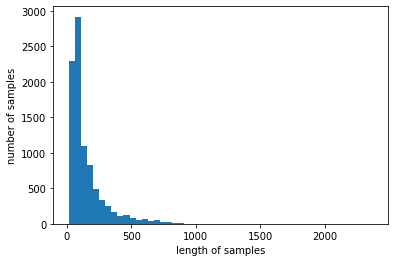

In [ ]:
plt.hist([len(s) for s in x_train], bins= 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


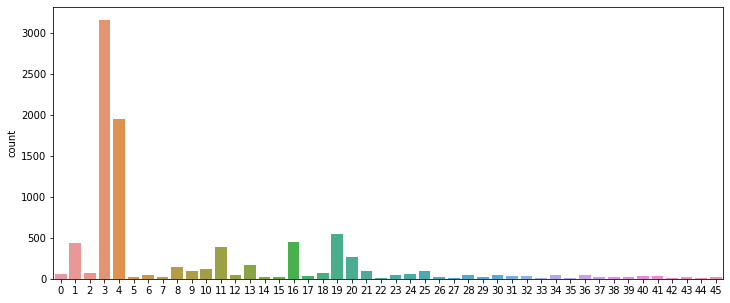

In [ ]:
fig, axe = plt.subplots(ncols= 1)
fig.set_size_inches(12, 5)
sns.countplot(y_train)

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수 : ")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수 : 
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [ ]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

557056/550378 [==============================] - 0s 0us/step


In [ ]:
word_index['the']

1

In [ ]:
word_index['it']

13

In [ ]:
index_to_word = {index +3 : word for word, index in word_index.items()}

In [ ]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [ ]:
# 0 <pad>
# 1 <sos>
# 2 <unk>
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

In [ ]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [ ]:
decoded = []
for i in range(len(x_train)):
  t = ' '.join([index_to_word[index] for index in x_train[i]])
  decoded.append(t)

x_train = decoded

In [ ]:
decoded = []
for i in range(len(x_test)):
  t = ' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)

x_test = decoded

In [ ]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [ ]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

https://wikidocs.net/35342

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)
# fit_transform : 학습할 때와 동일한 기반 설정으로 동일하게 테스트 데이터를 변환해야 하는 것

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
